# Natural Language Processing - Bill Text Exploration


Transform the raw data into feature vectors and these new features will be created using the existing dataset. Structure as follows:

Data Exploration
- Word Cloud 

Vectorizers
- Custom and Spacy Tokenizer
- Count Vectors as features
- TF-IDF Vectors as features

- Word level
- N-Gram level

Character level
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [58]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


In [59]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [60]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [61]:
df = query('SELECT BillID, Title, Summary, PassH, Cong FROM con_bills.bills')


In [62]:
df.tail()

,BillID,Title,Summary,PassH,Cong
17773,93-HR-9995,A bill to improve the conduct and regulation o...,Clean Elections Act -Title I: Federal Electio...,0,93
17774,93-HR-9996,A bill to amend the Truth-in-Lending-Act to pr...,Truth in Lending Act Amendments -Title I: Fai...,0,93
17775,93-HR-9997,A bill to provide income tax incentives for th...,Anti-Architectural Barriers Act - Allows an in...,0,93
17776,93-HR-9998,A bill to reorganize the governmental structur...,District of Columbia Self-Government and Gover...,0,93
17777,93-HR-9999,A bill to strengthen and improve the private r...,Omnibus Pension and Retirement Security Act - ...,0,93


In [63]:
df['PassH'].value_counts()

0    17010
1      768
Name: PassH, dtype: int64

In [64]:
blanks = []

for i, billID, title, summary, PassH, Cong in df.itertuples():  # iterate over the DataFrame
    if type(summary)==str:            # avoid NaN values
        if summary.isspace():         # test 'plot' for whitespace
            blanks.append(i)
                  
len(blanks)

0

# Wordcloud Exploration

Initial exploration of topics in dependent variable using wordcloud and stopword engineering.

Pass House 0 = Bills did not pass House

Pass House 1 = Bill passed House


In [65]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.add("concurrent")
stopwords.add("resolution")
stopwords.add("recognizing")
stopwords.add("providing")
stopwords.add("provide")
stopwords.add("bill")
stopwords.add("congressional")
stopwords.add("authorizing")
stopwords.add("authorize")
stopwords.add("designating")
stopwords.add("designate")
stopwords.add("printi")
stopwords.add("printing")
stopwords.add("printed")
stopwords.add("Congress")
stopwords.add("Authorizes")
stopwords.add("Provides")

In [66]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords, 
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


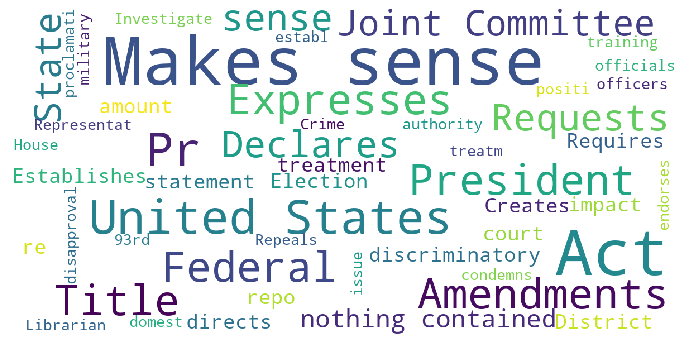

In [67]:
show_wordcloud(df[df['PassH']==0]['Summary'])

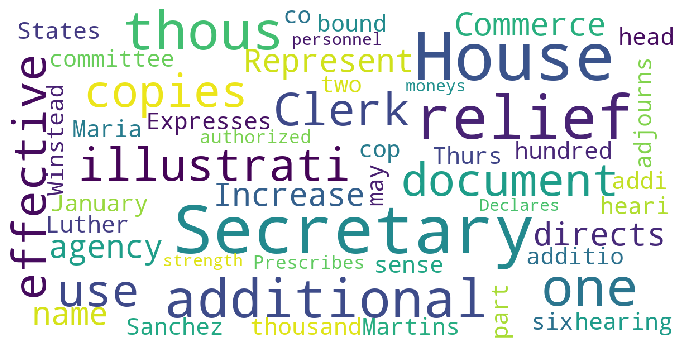

In [68]:
show_wordcloud(df[df['PassH']==1]['Summary'])

In [69]:
#Wordcloud on difference of frequencies

# Topic Modeling

**Split Training and Testing Data**

In [70]:
from sklearn import preprocessing

In [196]:
from sklearn.model_selection import train_test_split

X = df['Title']
y = df['PassH']

X_train, y_train1, X_test, y_test1 = train_test_split(X, y)

Encode our target column so that it can be used in machine learning models (may not be necessary since the data is already binary)

In [197]:
encoder = preprocessing.LabelEncoder()

y_train = encoder.fit_transform(y_train1)
y_test = encoder.fit_transform(y_test1)

## Feature Engineering


**Cleaning Text**

Test both the spacy tokenizer and personalized tokenizer against the data.

In [73]:
import spacy
from spacy.lang.en import English
# For part of speech tagging
import en_core_web_sm

nlp = English()
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [74]:
#Editing the stopwords list
spacy_stopwords.add('concurrent', 'resolution')

TypeError: add() takes exactly one argument (2 given)

In [75]:
#Lemmitization
for word in lem:
    print(word.text, word.lemma_)

TypeError: __call__() missing 1 required positional argument: 'text'

In [157]:
#Part of speech tagging
nlp_pos = en_core_web_sm.load()


In [78]:
#Define the spacy tokenizer
spacy_tokenizer = spacy.load('en_core_web_sm', disable =['tagger', 'parser', 'ner'])

In [83]:
import string
import re

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')


In [ ]:
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

lookups = Lookups()
lookups.add_table("lemma_rules", {"noun": [["s", ""]]})

lemmatizer = Lemmatizer(lookups)

In [224]:
#Define the custom tokenizer
def clean(text):
    
    text = text.lower()
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = replace_with_space.sub('',text)
    
    text = just_words.sub('', text)
    
#     text = ' '.join(word for word in text.split() if word not in stopwords)
    
    #Lemma here
    
    stopwords = set(STOPWORDS)
    
    return text
    
      

In [230]:
def tokenizer(text):
    
    text = clean(text)
    text = nlp(text)
    
    lem_text = []
    for word in text:
        lem_text.append(word.lemma_)
    
    return lem_text
    

In [226]:
test_fun = df.iloc[2200][2]
test_fun

'Federal Employee Labor Management Act -Title I:  Declaration of Policy- Declares it to be the policy of this Act that employees of the Federal Government shall have, and shall be protected in the exercise of, the right, freely and without fear of penalty or reprisal, to form, join, and assist any labor organization, including the right to participate in the management of any such organization and act for the organization in the capacity of an organization representative, including presentation of its views to officials of the executive branch of the Government, the Congress, or other appropriate authority.  Requires that the head of each Government department, agency, activity, organization, or function shall take such action as may be required to carry out the purpose of this Act and assure that no improper interference, restraint, coercion, or discrimination is practiced to discourage membership in any labor organization.Title II:  Definitions- Defines the terms used in this Act.Tit

In [227]:
type(test_fun)

str

In [228]:
clean(test_fun)

'federal employee labor management act title i  declaration of policy declares it to be the policy of this act that employees of the federal government shall have and shall be protected in the exercise of the right freely and without fear of penalty or reprisal to form join and assist any labor organization including the right to participate in the management of any such organization and act for the organization in the capacity of an organization representative including presentation of its views to officials of the executive branch of the government the congress or other appropriate authority  requires that the head of each government department agency activity organization or function shall take such action as may be required to carry out the purpose of this act and assure that no improper interference restraint coercion or discrimination is practiced to discourage membership in any labor organizationtitle ii  definitions defines the terms used in this acttitle iii  federal labor rel

In [213]:
tokenizer(test_fun)


['federal',
 'employee',
 'labor',
 'management',
 'act',
 'title',
 'i',
 'declaration',
 'policy',
 'declares',
 'policy',
 'act',
 'employees',
 'federal',
 'government',
 'protected',
 'exercise',
 'right',
 'freely',
 'without',
 'fear',
 'penalty',
 'reprisal',
 'form',
 'join',
 'assist',
 'labor',
 'organization',
 'including',
 'right',
 'participate',
 'management',
 'organization',
 'act',
 'organization',
 'capacity',
 'organization',
 'representative',
 'including',
 'presentation',
 'views',
 'officials',
 'executive',
 'branch',
 'government',
 'congress',
 'appropriate',
 'authority',
 'requires',
 'head',
 'government',
 'department',
 'agency',
 'activity',
 'organization',
 'function',
 'take',
 'action',
 'may',
 'required',
 'carry',
 'purpose',
 'act',
 'assure',
 'improper',
 'interference',
 'restraint',
 'coercion',
 'discrimination',
 'practiced',
 'discourage',
 'membership',
 'labor',
 'organizationtitle',
 'ii',
 'definitions',
 'defines',
 'terms',
 'used'

In [202]:
spacy_tokenizer(test_fun)

Federal Employee Labor Management Act -Title I:  Declaration of Policy- Declares it to be the policy of this Act that employees of the Federal Government shall have, and shall be protected in the exercise of, the right, freely and without fear of penalty or reprisal, to form, join, and assist any labor organization, including the right to participate in the management of any such organization and act for the organization in the capacity of an organization representative, including presentation of its views to officials of the executive branch of the Government, the Congress, or other appropriate authority.  Requires that the head of each Government department, agency, activity, organization, or function shall take such action as may be required to carry out the purpose of this Act and assure that no improper interference, restraint, coercion, or discrimination is practiced to discourage membership in any labor organization.Title II:  Definitions- Defines the terms used in this Act.Titl

**Saving to DF**

In [215]:
df['clean_summaries'] = df.apply(lambda row: clean(row['Summary']), axis=1)

In [216]:
df['tokenized_summaries'] = df.apply(lambda row: tokenizer(row['Summary']), axis=1)


In [217]:
df.head()

,BillID,Title,Summary,PassH,Cong,tokenized_summaries,clean_summaries
0,93-HCONRES-1,A concurrent resolution making the necessary a...,"Provides that effective from January 3, 1973, ...",1,93,"[provides, effective, january, joint, committe...",provides effective january joint committee cre...
1,93-HCONRES-10,A concurrent resolution expressing the sense o...,Makes it the sense of the Congress that the re...,0,93,"[makes, sense, congress, regulation, insurance...",makes sense congress regulation insurance gene...
2,93-HCONRES-100,Concurrent resolution expressing the disapprov...,Expresses the disapproval of Congress of all p...,0,93,"[expresses, disapproval, congress, proposals, ...",expresses disapproval congress proposals conta...
3,93-HCONRES-101,Concurrent resolution expressing the sense of ...,Makes it the sense of the Congress that the Pr...,0,93,"[makes, sense, congress, president, take, step...",makes sense congress president take steps may ...
4,93-HCONRES-102,Concurrent resolution expressing the sense of ...,Makes it the sense of the Congress that the Pr...,0,93,"[makes, sense, congress, president, take, step...",makes sense congress president take steps may ...


**CountVectorizer**

Every row represents a document in the corpus, every column represents a term in the document, every cell represents the frequency count of a particular term in a particular document.

Tuning: analyzer, vectorizer, max_features, max_df, min_df, n_grams

In [208]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(analyzer = 'word', tokenizer = tokenizer, ngram_range = (1,2))
cv = count_vect.fit_transform(X_train, y_train)

# xtrain_cv =  count_vect.transform(X_train)
# xvalid_cv =  count_vect.transform(X_test)

<13333x56045 sparse matrix of type '<class 'numpy.int64'>'
	with 374210 stored elements in Compressed Sparse Row format>

In [ ]:
#decide if i want to use these
params = {'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 5000, 10000, 50000),
        'vect__ngram_range': ((1, 1), (1, 2))
         }

In [ ]:
#Gridsearch

**Exploring Stored Words**

In [ ]:
len(cv.get_feature_names())

In [ ]:
cv.get_feature_names()

In [ ]:
import random

#get ten random words from each

for i in range(10):
    word_id = random.randomint(0,) #second should be len of cv
    print(cv.get_feature_names()[word_id])

Look at model components:

In [ ]:
lda_model.components_

In [ ]:
single_topic = lda_model.components_[0]

In [ ]:
# Returns the indices that would sort this array.
single_topic.argsort()

#look at the most and least representative words!

In [ ]:
# Word least representative of this topic
single_topic[XXX]

#first round goes from 0.05 to 106.1

In [ ]:
# Word most representative of this topic
single_topic[XXX]

Look at the top fifteen for each topic:

In [ ]:
for index,topic in enumerate(lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#print top fifteen words for each topic
#increase number of topics to get more specific topics
#go back and clean some of the data based on answers

NEXT: Dominant topic visualizations

'LDA-Guided-Project'

**Topic Modeling - LDA**

LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

In [229]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
# Build LDA Model
#focus on number topics, max iteration, learning decay
lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
                                      max_iter=20,  
                                      learning_decay=0.5,    # Max learning iterations (how many times going over whole dataset)
                                      learning_method='online',   #constantly update with new data or batch
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

print(lda_model)  # Model attributes

In [ ]:
# This can take awhile, we're dealing with a large amount of documents!

lda_output = lda_model.fit_transform(cv)


**Evaluation of Model:**

In [ ]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(cv))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(cv))

# See model parameters
print(lda_model.get_params())

**Data Mapper Pipeline**


This allow each column to be mapped to different encoders.

https://pypi.org/project/dataframe-mapper/

In [27]:
!pip install dataframe-mapper

In [ ]:
column_tuples = [
    ('Sales', None),
    ('ShelveLoc', LabelEncoder()),
    ('Urban', LabelEncoder()), 
    ('US', LabelEncoder())]

mapper = DataFrameMapper(column_tuples, default=StandardScaler())
mapper_fit = mapper.fit(train)